In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


In [3]:
stock_data = yf.download("AAPL", start="2010-01-01", end="2023-12-31")
stock_data.to_csv("AAPL_historical_data.csv")

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2010-01-04,6.447411,7.643214,7.660714,7.585000,7.622500,493729600
2010-01-05,6.458560,7.656429,7.699643,7.616071,7.664286,601904800
2010-01-06,6.355827,7.534643,7.686786,7.526786,7.656429,552160000
2010-01-07,6.344075,7.520714,7.571429,7.466071,7.562500,477131200
2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800


In [5]:
def clean_data(data):
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])


    data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]


   

    data.rename(columns={'Volume_AAPL': 'Volume',
                               'Adj Close_AAPL': 'Adj Close',
                                'Close_AAPL': 'Close',
                               'High_AAPL':'High',
                               'Low_AAPL':'Low',
                               'Open_AAPL':'Open'
                              }, inplace=True)
    return data

In [6]:
def add_column(data):
    data['day_of_week']=data['Date'].dt.dayofweek
    data['month']=data['Date'].dt.month
    data['day_of_year']=data['Date'].dt.dayofyear
    data['day_sin']=np.sin(2 * np.pi * data['day_of_year'] / 365)
    data['day_cos']=np.cos(2 * np.pi * data['day_of_year'] / 365)
    data['date_trend']=data['Date'].apply(lambda x: x.toordinal())
    data['SMA_20']=data['Close'].rolling(window=20).mean()
    data['EMA']=data['Close'].ewm(span=20,adjust=False).mean()

    #RSI calculation
    delta=data['Close'].diff()
    gain=delta.where(delta>0,0)
    loss=delta.where(delta<0,0)
    avg_gain=gain.rolling(window=14).mean()
    avg_loss=gain.rolling(window=14).mean()
    rs=avg_gain/avg_loss
    data['RSI']=100 - (100/(1+rs))

    #Bollinger bands
    data['Middle_Band']=data['Close'].rolling(window=20).mean()
    data['std']=data['Close'].rolling(window=20).std()
    data['Upper_Band']=data['Middle_Band'] + 2 * data['std']
    data['Lower_Band']=data['Middle_Band'] * 2*data['std']

    #Money flow index
    data['typcal_price']=(data['High']+data['Low']+data['Close']) /3
    data['RMF']=data['typcal_price'] * data['Volume']
    data['MF_Positive']=np.where(data['typcal_price'].diff() >0, data['RMF'], 0)
    data['MF_Negative']=np.where(data['typcal_price'].diff() <0, data['RMF'], 0)

    pos_sum=data['MF_Positive'].rolling(window=14).sum()
    neg_sum=data['MF_Negative'].rolling(window=14).sum()
    m_ratio=pos_sum/neg_sum
    data['MFI']=100 - (100/(100+m_ratio))

    data.dropna(inplace=True)

    return data

In [7]:
def preprocess(data):
    data=clean_data(data)
    data=add_column(data)
    return data

In [8]:
stock_data=preprocess(stock_data)

In [9]:
stock_data.head(50)

,Date,Adj Close,Close,High,Low,Open,Volume,day_of_week,month,day_of_year,...,RSI,Middle_Band,std,Upper_Band,Lower_Band,typcal_price,RMF,MF_Positive,MF_Negative,MFI
19,2010-02-01,5.866569,6.954643,7.000000,6.832143,6.870357,749876400,0,2,32,...,50.0,7.395214,0.233437,7.862088,3.452629,6.928929,5.195840e+09,0.000000e+00,5.195840e+09,99.005840
20,2010-02-02,5.900611,6.995000,7.011429,6.906429,6.996786,698342400,1,2,33,...,50.0,7.362804,0.242033,7.846870,3.564083,6.970953,4.868112e+09,4.868112e+09,0.000000e+00,99.007181
21,2010-02-03,6.002139,7.115357,7.150000,6.943571,6.970357,615328000,2,2,34,...,50.0,7.335750,0.237686,7.811121,3.487207,7.069643,4.350149e+09,4.350149e+09,0.000000e+00,99.007152
22,2010-02-04,5.785831,6.858929,7.084643,6.841786,7.026071,757652000,3,2,35,...,50.0,7.301964,0.255298,7.812561,3.728356,6.928453,5.249356e+09,0.000000e+00,5.249356e+09,99.006000
23,2010-02-05,5.888563,6.980714,7.000000,6.816071,6.879643,850306800,4,2,36,...,50.0,7.274964,0.259467,7.793898,3.775222,6.932262,5.894549e+09,5.894549e+09,0.000000e+00,99.007514
24,2010-02-08,5.848191,6.932857,7.067143,6.928571,6.988929,478270800,0,2,39,...,50.0,7.243071,0.260401,7.763873,3.772203,6.976190,3.336508e+09,3.336508e+09,0.000000e+00,99.007125
25,2010-02-09,5.910556,7.006786,7.053571,6.955357,7.015000,632886800,1,2,40,...,50.0,7.218214,0.257905,7.734025,3.723234,7.005238,4.433523e+09,4.433523e+09,0.000000e+00,99.008620
26,2010-02-10,5.878318,6.968571,7.021429,6.937857,6.996071,370361600,2,2,41,...,50.0,7.195714,0.259132,7.713979,3.729286,6.975952,2.583625e+09,0.000000e+00,2.583625e+09,99.008962
27,2010-02-11,5.985269,7.095357,7.133929,6.930714,6.960000,550345600,3,2,42,...,50.0,7.174321,0.248099,7.670519,3.559878,7.053333,3.881771e+09,3.881771e+09,0.000000e+00,99.011160
28,2010-02-12,6.036786,7.156429,7.201429,6.982143,7.075357,655468800,4,2,43,...,50.0,7.158161,0.237463,7.633086,3.399591,7.113334,4.662568e+09,4.662568e+09,0.000000e+00,99.010463


In [10]:
corr_matrix=stock_data.corr()
corr_matrix['Adj Close']

Date            0.885349
Adj Close       1.000000
Close           0.999951
High            0.999833
Low             0.999851
Open            0.999716
Volume         -0.531531
day_of_week     0.001808
month           0.068728
day_of_year     0.068632
day_sin        -0.063971
day_cos         0.010455
date_trend      0.885349
SMA_20          0.998064
EMA             0.998604
RSI                  NaN
Middle_Band     0.998064
std             0.845203
Upper_Band      0.997421
Lower_Band      0.896724
typcal_price    0.999918
RMF             0.534678
MF_Positive     0.261081
MF_Negative     0.229052
MFI            -0.045126
Name: Adj Close, dtype: float64

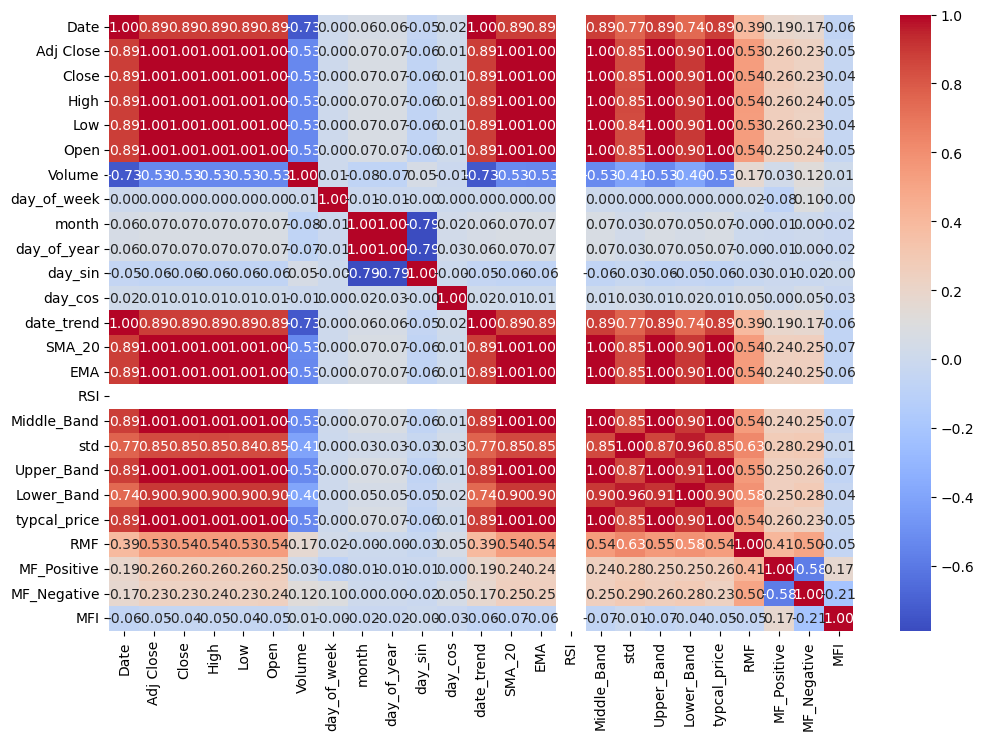

In [45]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm',fmt=".2f")
plt.show()

In [11]:
corr_features = corr_matrix.index[corr_matrix['Adj Close'] > 0.8].tolist()

numeric_features= [col for col in corr_features if col not in ['Date','Adj Close','Close']]
date_feature=['Date']
target_feature=['Adj Close']                       

scaler =  StandardScaler()

for feature in numeric_features:
    stock_data[feature]=scaler.fit_transform(stock_data[[feature]])

In [12]:
target_feature

['Adj Close']

In [13]:
X=stock_data[numeric_features]
y=stock_data[target_feature]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
model=Ridge()
model.fit(X_train,y_train)
y_pred=model.predict(X_test) 

In [15]:
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')          

Mean Squared Error: 0.6745161978090957
R² Score: 0.9997742787165244


In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores)
print("Mean R²:", scores.mean())

Cross-Validation R² Scores: [0.9997789  0.999771   0.99976698 0.99976795 0.9998014 ]
Mean R²: 0.9997772452909983


In [17]:
print(model.alpha)

1.0


In [41]:
param_grid = {'alpha': [ 0.1,1,10,100 ,1000]}


grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


best_ridge_model = grid_search.best_estimator_


best_y_pred = best_ridge_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_y_pred)
best_r2 = r2_score(y_test, best_y_pred)

print(f'Best Alpha: {grid_search.best_params_["alpha"]}')
print(f'Best Mean Squared Error: {best_mse}')
print(f'Best R² Score: {best_r2}')


Best Alpha: 0.1
Best Mean Squared Error: 0.4216578970603963
Best R² Score: 0.9998588956617777


In [42]:
train_pred=best_ridge_model.predict(X_train)
test_pred=best_ridge_model.predict(X_test)

train_mse=mean_squared_error(y_train,train_pred)
train_r2=r2_score(y_train,train_pred)

test_mse=mean_squared_error(test_pred,y_test)
test_r2=r2_score(test_pred,y_test)

print(f"Train MSE: {train_mse}, Train R2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R2 :{test_r2}")

Train MSE: 0.4202029388374026, Train R2: 0.9998649459325152
Test MSE: 0.4216578970603963, Test R2 :0.9998591503287365


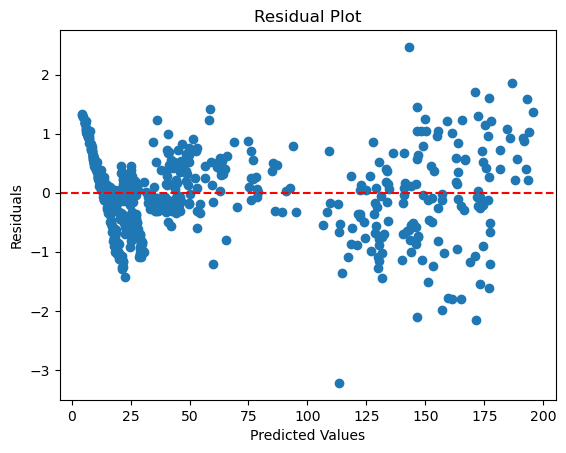

In [43]:
residuals = y_test - test_pred

plt.scatter(test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
